# SELF ATTENTION GAN TUTORIAL

**Author** - [Avik Pal](https://avik-pal.github.io)

**[Try this tutorial on Colab](https://colab.research.google.com/drive/1BHRrau_awrfisc7z-q228hCRvt_TE3u-)**

In this tutorial we shall be implementing **Self Attention GAN** (SAGAN), which makes use of the novel **Self Attention** layer as proposed in [
Self-Attention Generative Adversarial Networks by Zhang et. al.](https://arxiv.org/abs/1805.08318). **Self Attention**, is incorporated in both the **Generator** as well as the **Discriminator**, leading to *state-of-the-art* results on ImageNet

The tutorial helps you with the following:

1. Understanding how to use the **torchgan.layers API**.
2. Creating custom Generator and Discriminator architectures that fit in seamlessly with **TorchGAN'**  by simply extending the base **torchgan.models.Generator** and **torchgan.models.Discriminator** classes
3. Visualizing the samples generated on the **CelebA Dataset**. We stick to such a simple dataset for illustration purposes and convergence time issues

This tutorial assumes that your system has **Pytorch** and **torchgan** installed properly. If not, head over to the installation instructions on the [official documentation website](https://torchgan.readthedocs.io/en/latest/).

In [1]:
# General Imports
import os
import random
import matplotlib.pyplot as plt
import numpy as np
# Pytorch and Torchvision Imports
import torch
import torchvision
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
# Torchgan Imports
import torchgan
from torchgan.layers import SpectralNorm2d, SelfAttention2d
from torchgan.models import Generator, Discriminator
from torchgan.losses import WassersteinGeneratorLoss, WassersteinDiscriminatorLoss, WassersteinGradientPenalty
from torchgan.trainer import Trainer

In [2]:
# Set random seed for reproducibility
manualSeed = 144
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  144


## LOAD THE DATASET

Before starting this tutorial, download the [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Extract the file named **img_align_celeba.zip**. The directory structure should be:

```
--> path/to/data
    --> img_align_celeba
        --> 188242.jpg
        --> 173822.jpg
        --> 284702.jpg
        --> 537394.jpg
           ...
```

We make the following transforms before feeding the **CelebA Dataset** into the networks

1. By convention, the default input size in **torchgan.models** is a power of 2 and at least 16. Hence we shall be resizing the images to $3 \times 64 \times 64$.

2. First, we will make a **center crop** of $160 \times 160$ of the images. Next we resize the images to $3 \times 64 \times 64$. Direct resizing, affects the quality of the image. We want to generate faces, hence we want a major portion of the images to be filled by the faces.

3. The output quality of GANs is improved when the images are normalized with a mean and standard deviation of **0.5**, thereby constraining pixel values of the input in the range $(-1, 1)$.

Finally the **torchgan.trainer.Trainer** needs a **DataLoader** as input. So we are going to construct a DataLoader for the MNIST Dataset.

In [3]:
dataset = dsets.ImageFolder("./CelebA",
                            transform=transforms.Compose([transforms.CenterCrop(160),
                                                          transforms.Resize((64, 64)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [4]:
dataloader = data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

## GENERATOR MODEL

The SAGANGenerator receives an input noise vector of size $batch\ size \times encoding\ dims$. The output must be a torch Tensor of size $batch\ size \times 3 \times 64 \times 64$ conforming to the input MNIST size. We transform the noise to the image in the following way:

1. **Channel Dimension**: $encoding\ dims \rightarrow d \rightarrow \frac{d}{2} \rightarrow \frac{d}{4} \rightarrow \frac{d}{8} \rightarrow 1$.
2. **Image size**: $(1 \times 1) \rightarrow (4 \times 4) \rightarrow (8 \times 8) \rightarrow (16 \times 16) \rightarrow (32 \times 32) \rightarrow (64 \times 64)$.

We are going to use **LeakyReLU** as the activation. Using ReLU will kill most of the gradients and hence convergence is critically slowed down. Hence it is a valid choice for the activation. At the end of the model we use a **Tanh** activation. This ensures that the pixel values range from $(-1\ to\ 1)$.

---

**SelfAttention2d** is present out-of-box in torchgan. Self Attention simply learns an attention map to learn ot attend to certain places of the image. It contains 3 convolutional layers, named **query**, **key** and **value**. The weights of these layers are learned. We compute the attention map by:

$$attention = softmax((query(x)^T \times key(x)))$$
$$output = \gamma \times value(x) \times attention + x $$

$\gamma$ is simply a scaling parameter which is also learning. Its value is initially set to 0. As result in the beginning, the Self Attention Layer does nothing. As the network starts learning the features the value of $\gamma$ increases and so does the effect of the attention map. This is done to ensure that the model initially focusses on learning the local features (which are relatively easy to learn). Once it has learnt to detect the local features it focusses on learning the more
global features.

For more information on SelfAttention2d, use `help(SelfAttention2d)`.

---

The Generator model needs 2 inputs, the $1^{st}$ one is the **encoding_dims** and the $2^{nd}$ one is the **label_type**. Since SAGAN is not a conditional model, we are going to set the **label_type** as **'none'**. For conditioned models there are 2 options - **'generated'** and **'required'**. We shall discuss them in detail in later tutorials.

The training of SAGAN is same as the standard GANs, it is only an architectural improvement. Hence subclassing the Generator, allows us to use the default **train_ops**. We shall be discussing on how to write a custom **train_ops** in a future tutorial.

In [5]:
class SAGANGenerator(Generator):
    def __init__(self, encoding_dims=100, step_channels=64):
        super(SAGANGenerator, self).__init__(encoding_dims, 'none')
        d = int(step_channels * 8)
        self.model = nn.Sequential(
            SpectralNorm2d(nn.ConvTranspose2d(self.encoding_dims, d, 4, 1, 0, bias=True)),
            nn.BatchNorm2d(d), nn.LeakyReLU(0.2),
            SpectralNorm2d(nn.ConvTranspose2d(d, d // 2, 4, 2, 1, bias=True)),
            nn.BatchNorm2d(d // 2), nn.LeakyReLU(0.2),
            SpectralNorm2d(nn.ConvTranspose2d(d // 2, d // 4, 4, 2, 1, bias=True)),
            nn.BatchNorm2d(d // 4), nn.LeakyReLU(0.2),
            SelfAttention2d(d // 4),
            SpectralNorm2d(nn.ConvTranspose2d(d // 4, d // 8, 4, 2, 1, bias=True)),
            nn.BatchNorm2d(d // 8),
            SelfAttention2d(d // 8),
            SpectralNorm2d(nn.ConvTranspose2d(d // 8, 3, 4, 2, 1, bias=True)), nn.Tanh())

    def forward(self, x):
        x = x.view(-1, x.size(1), 1, 1)
        return self.model(x)

## DISCRIMINATOR MODEL

The SAGANDiscriminator receives an image in the form of a torch Tensor of size $batch\ size \times 3 \times 64 \times 64$. It must output a tensor of size $batch\ size$, where each value corresponds to the confidence of whether or not that is image is real. Since we use a **Tanh** activation at the end of the model, the outputs **cannot be interpreted as probabilities**. Instead we interpret them as follows:

1. A **Higher** value (*closer to 1.0*) indicates that the discriminator believes the image to be a real one.
2. A **Lower** value (*closer to -1.0*) indicates that the discriminator believes the image to be a fake one.

---

For reasons same as above we use a **LeakyReLU** activation. The conversion of the image tensor to the confidence scores are as follows:

1. **Channel Dimension**: $1 \rightarrow d \rightarrow 2 \times d \rightarrow 4 \times d \rightarrow 8 \times d \rightarrow 1$.
2. **Image size**: $(64 \times 64) \rightarrow (32 \times 32) \rightarrow (16 \times 16) \rightarrow (8 \times 8) \rightarrow (4 \times 4) \rightarrow (1 \times 1)$.

---

The Discriminator also needs 2 inputs. The $1^{st}$ one is the channel dimension of the input image. In our case, we have grayscale images so this value is *1*. The $2^{nd}$ argument is the **label_type**, which is again **'none'**

In [6]:
class SAGANDiscriminator(Discriminator):
    def __init__(self, step_channels=64):
        super(SAGANDiscriminator, self).__init__(3, 'none')
        d = step_channels
        self.model = nn.Sequential(
            SpectralNorm2d(nn.Conv2d(self.input_dims, d, 4, 2, 1, bias=True)),
            nn.BatchNorm2d(d), nn.LeakyReLU(0.2),
            SpectralNorm2d(nn.Conv2d(d, d * 2, 4, 2, 1, bias=True)),
            nn.BatchNorm2d(d * 2), nn.LeakyReLU(0.2),
            SpectralNorm2d(nn.Conv2d(d * 2, d * 4, 4, 2, 1, bias=True)),
            nn.BatchNorm2d(d * 4), nn.LeakyReLU(0.2),
            SelfAttention2d(d * 4),
            SpectralNorm2d(nn.Conv2d(d * 4, d * 8, 4, 2, 1, bias=True)),
            nn.BatchNorm2d(d * 8),
            SelfAttention2d(d * 8),
            SpectralNorm2d(nn.Conv2d(d * 8, 1, 4, 1, 0, bias=True)), nn.Tanh())

    def forward(self, x):
        return self.model(x)

## MODEL PARAMETERS & HYPERPARAMETERS

In this section we are going to define how the model is going to look like, what their optimizers are going to be and every other possible hyperparameter. We use a dictionary to feed the input into the trainer. We believe it to be a much cleaner approach than individual arguments which tend to limit the capacity of the Trainer.

---

We follow a standard naming system for parsing arguments. **name** refers to the **class** whose object is to be created. **args** contains the arguments that will be fed into the **class** while instantiating it. The keys refer to the **variable names** with which the **object** shall be stored in the **Trainer**. This storage pattern allows us to have customs **train_ops** for Losses with no furthur headaches, but thats again for a future discussion. The items in the dictionary are allowed to have the following keys:

1. "name": The class name for the model.
2. "args": Arguments fed into the class.
3. "optimizer": A dictionary containing the following key-value pairs
    * "name"
    * "args"
    * "var": Variable name for the optimizer. This is an optional argument. If this is not provided, we assign the optimizer the name **optimizer_{}** where {} refers to the variable name of the model.
    * "scheduler": Optional scheduler associated with the optimizer. Again this is a dictionary with the following keys
        * "name"
        * "args"

---

Lets see the interpretation of the `network_params` defined in the following code block. This dictionary gets interpreted as follows in the Trainer:

```python
generator = SAGANGenerator(step_channels = 32)
optimizer_generator = Adam(generator.parameters(), lr = 0.0001, betas = (0.0, 0.999))

discriminator = SAGANDiscriminator(step_channels = 32)
optimizer_discriminator = Adam(discriminator.parameters(), lr = 0.0004, betas = (0.0, 0.999))
```

As observed we are using the **TTUR (Two Timescale Update  Rule)** for training the models. Hence we can easily customize most of the training pipeline even with such high levels of abstraction.

In [7]:
network_params = {
    "generator": {"name": SAGANGenerator, "args": {"step_channels": 32},
                  "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.0, 0.999)}}},
    "discriminator": {"name": SAGANDiscriminator, "args": {"step_channels": 32},
                      "optimizer": {"name": Adam, "args": {"lr": 0.0004, "betas": (0.0, 0.999)}}}
}

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 20
else:
    device = torch.device("cpu")
    epochs = 10

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 20


We need to feed a list of losses to the trainer. These losses control the optimization of the model weights. We are going to use the following losses, all of which are defined in the **torchgan.losses** module.

1. WassersteinGeneratorLoss
2. WassersteinDiscriminatorLoss

We need the **clip** parameter to enforce the **Lipschitz condition**.

In [9]:
losses_list = [WassersteinGeneratorLoss(), WassersteinDiscriminatorLoss(clip=(-0.01, 0.01))]

## VISUALIZE THE TRAINING DATA

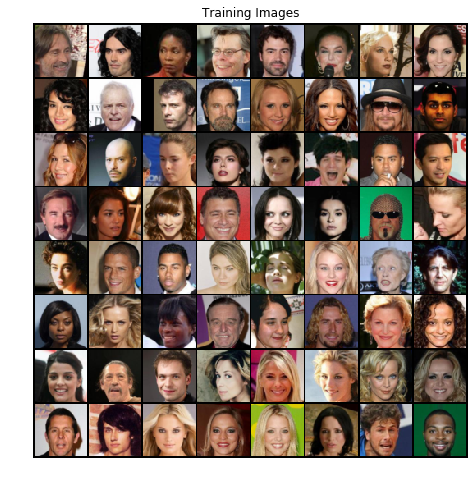

In [10]:
# Plot some of the training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## TRAINING THE GENERATOR & DISCRIMINATOR

Next we simply feed the network descriptors and the losses we defined previously into the Trainer. Then we pass the **CelebA DataLoader** to the trainer object and wait for training to complete.

---

Important information for visualizing the performance of the GAN will be printed to the console. The best and recommended way to visualize the training is to use **tensorboardX**. It plots all the data and periodically displays the generated images. It allows us to track failure of the model early.

In [11]:
trainer = Trainer(network_params, losses_list, sample_size=64, epochs=epochs, device=device)

In [12]:
trainer(dataloader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
generator Mean Gradients : 1.77113134345256
discriminator Mean Gradients : 168.43573220352587
Mean Running Discriminator Loss : -0.22537715325384405
Mean Running Generator Loss : 0.14026778625453137
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
generator Mean Gradients : 0.9709061059735268
discriminator Mean Gradients : 157.5974371968578
Mean Running Discriminator Loss : -0.16900254713096868
Mean Running Generator Loss : 0.14780808075226576
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
generator Mean Gradients : 0.6489546410498336
discriminator Mean Gradients : 114.98364009010012
Mean Running Discriminator Loss : -0.11867836168094256
Mean Running Generator Loss : 0.19490897187906048
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary

In [13]:
trainer.complete()

Saving Model at './model/gan0.model'


## VISUALIZE THE GENERATED DATA

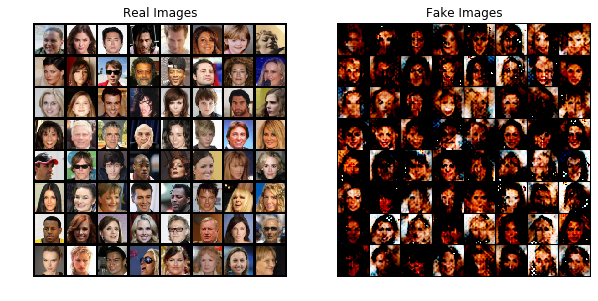

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()